# Assignment 4
Erik Strand | 6 November 2020

Research questions: How does the distribution of rideshares in Chicago reflect existing spatial inequities? How did rideshare usage change between a typical weekday in 2019 (pre-COVID) and 2020? What do these changes reveal about possible further inequity?

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import contextily as ctx
from shapely.geometry import shape
import matplotlib.pyplot as plt
from urllib.parse import urlencode
import urllib.request, json
from plotnine import *
from statistics import mean
import networkx as nx #library supporting networks

A note: I used data for both May 1, 2020, and May 1, 2019, for the purposes of a comparative analysis. Rather than read in both datasets simultaneously, I set the code below up to work with both datasets. I ran it once for the 2020 data, exported the figures, and then re-ran the entire code on the 2019 data. 

In [2]:
# read in Chicago rideshare data for May 1, 2020
# downloaded to local file due to API not functioning
may_1_20 = pd.read_csv("../data/chicago_rides_may_1_2020.csv") # interchangeable w/ 2019 data file

may_1_20.head()

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,...,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,ffab19895af3e8db5a3e3e59dbcbb902011cd406,05/01/2020 12:00:00 AM,05/01/2020 12:15:00 AM,473,3.1,NaN,NaN,40.0,35.0,7.5,...,3.08,10.58,False,1,41.792357,-87.617931,POINT (-87.6179313803 41.7923572233),41.835118,-87.618678,POINT (-87.6186777673 41.8351179863)
1,fe12175e8d4ce9c6055a12c08f12763bdacf6c59,05/01/2020 12:00:00 AM,05/01/2020 12:15:00 AM,746,3.1,NaN,NaN,69.0,43.0,7.5,...,3.08,10.58,False,1,41.763247,-87.616134,POINT (-87.6161341112 41.7632467988),41.761578,-87.572782,POINT (-87.5727819867 41.7615779081)
2,fe0f4ab416d91ffe7e7a6602093e1e9fb51b593e,05/01/2020 12:00:00 AM,05/01/2020 12:15:00 AM,1147,14.7,1.703127e+10,1.703171e+10,27.0,71.0,17.5,...,3.08,20.58,False,1,41.877360,-87.703562,POINT (-87.7035622954 41.8773599627),41.747837,-87.648813,POINT (-87.6488131191 41.7478369814)
3,fdb9ec7b21d1936018dbb0436e9e7a9fdb8c5c51,05/01/2020 12:00:00 AM,05/01/2020 12:00:00 AM,386,1.9,NaN,NaN,27.0,23.0,10.0,...,3.08,13.08,False,1,41.878914,-87.705897,POINT (-87.7058971305 41.8789144956),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026)
4,fdb704a20c8522185fd597fae97c05de7b372b1e,05/01/2020 12:00:00 AM,05/01/2020 12:15:00 AM,964,2.1,NaN,NaN,67.0,67.0,7.5,...,3.08,10.58,False,1,41.775929,-87.666596,POINT (-87.6665962653 41.7759288274),41.775929,-87.666596,POINT (-87.6665962653 41.7759288274)


In [3]:
may_1_20["lat"] = round(may_1_20["Pickup Centroid Latitude"], 2)
may_1_20["lon"] = round(may_1_20["Pickup Centroid Longitude"], 2)

may_1_20["latlon"] = list(zip(may_1_20.lat, may_1_20.lon))

may_1_20["lat_end"] = round(may_1_20["Dropoff Centroid Latitude"], 2)
may_1_20["lon_end"] = round(may_1_20["Dropoff Centroid Longitude"], 2)

may_1_20["latlon_end"] = list(zip(may_1_20.lat_end, may_1_20.lon_end))

may_1_20.head()

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,...,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,lat,lon,latlon,lat_end,lon_end,latlon_end
0,ffab19895af3e8db5a3e3e59dbcbb902011cd406,05/01/2020 12:00:00 AM,05/01/2020 12:15:00 AM,473,3.1,NaN,NaN,40.0,35.0,7.5,...,POINT (-87.6179313803 41.7923572233),41.835118,-87.618678,POINT (-87.6186777673 41.8351179863),41.79,-87.62,"(41.79, -87.62)",41.84,-87.62,"(41.84, -87.62)"
1,fe12175e8d4ce9c6055a12c08f12763bdacf6c59,05/01/2020 12:00:00 AM,05/01/2020 12:15:00 AM,746,3.1,NaN,NaN,69.0,43.0,7.5,...,POINT (-87.6161341112 41.7632467988),41.761578,-87.572782,POINT (-87.5727819867 41.7615779081),41.76,-87.62,"(41.76, -87.62)",41.76,-87.57,"(41.76, -87.57)"
2,fe0f4ab416d91ffe7e7a6602093e1e9fb51b593e,05/01/2020 12:00:00 AM,05/01/2020 12:15:00 AM,1147,14.7,1.703127e+10,1.703171e+10,27.0,71.0,17.5,...,POINT (-87.7035622954 41.8773599627),41.747837,-87.648813,POINT (-87.6488131191 41.7478369814),41.88,-87.70,"(41.88, -87.7)",41.75,-87.65,"(41.75, -87.65)"
3,fdb9ec7b21d1936018dbb0436e9e7a9fdb8c5c51,05/01/2020 12:00:00 AM,05/01/2020 12:00:00 AM,386,1.9,NaN,NaN,27.0,23.0,10.0,...,POINT (-87.7058971305 41.8789144956),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026),41.88,-87.71,"(41.88, -87.71)",41.90,-87.72,"(41.9, -87.72)"
4,fdb704a20c8522185fd597fae97c05de7b372b1e,05/01/2020 12:00:00 AM,05/01/2020 12:15:00 AM,964,2.1,NaN,NaN,67.0,67.0,7.5,...,POINT (-87.6665962653 41.7759288274),41.775929,-87.666596,POINT (-87.6665962653 41.7759288274),41.78,-87.67,"(41.78, -87.67)",41.78,-87.67,"(41.78, -87.67)"


In [4]:
counts_5120_start = may_1_20[["latlon", "Trip ID"]].groupby("latlon").agg({"Trip ID": "count"})
print(counts_5120_start.count(0))
counts_5120_start.head(20)
counts_5120_start.index.toname = "latlon"
counts_5120_start.reset_index(inplace=True)
counts_5120_start.sort_values(by = "Trip ID", ascending=False).head(394)

# filtering to remove all of the (nan, nan) rows
counts_over1 = counts_5120_start["Trip ID"] > 1

counts_5120_start = counts_5120_start[counts_over1]
counts_5120_start.head()

Trip ID    6393
dtype: int64


,latlon,Trip ID
0,"(41.79, -87.62)",548
12,"(41.97, -87.74)",6
104,"(41.8, -87.75)",2
256,"(42.01, -87.7)",2
358,"(41.82, -87.61)",3


In [5]:
counts_5120_end = may_1_20[["latlon_end", "Trip ID"]].groupby("latlon_end").agg({"Trip ID": "count"})
print(counts_5120_end.count(0))
counts_5120_end.head(20)
counts_5120_end.index.toname = "latlon_end"
counts_5120_end.reset_index(inplace=True)
counts_5120_end["latlon"] = counts_5120_end["latlon_end"]
counts_5120_end = counts_5120_end[["latlon", "Trip ID"]]

# filtering to remove all of the (nan, nan) rows
counts_over1 = counts_5120_end["Trip ID"] > 1

counts_5120_end = counts_5120_end[counts_over1]
counts_5120_end.head()

Trip ID    6839
dtype: int64


,latlon,Trip ID
0,"(41.84, -87.62)",670
42,"(41.84, -87.66)",5
84,"(41.92, -87.63)",5
104,"(41.92, -87.68)",6
168,"(41.71, -87.65)",5


In [6]:
nodes = pd.concat([counts_5120_start, counts_5120_end])
nodes = nodes[["latlon"]].drop_duplicates()
nodes = nodes.reset_index()
nodes[["lat", "lon"]] = pd.DataFrame(nodes["latlon"].tolist(), index = nodes.index)
nodes["index"] = nodes["index"].apply(str)

print(len(nodes))
print(type(nodes["index"][1]))
nodes.head()

415
<class 'str'>


,index,latlon,lat,lon
0,0,"(41.79, -87.62)",41.79,-87.62
1,12,"(41.97, -87.74)",41.97,-87.74
2,104,"(41.8, -87.75)",41.80,-87.75
3,256,"(42.01, -87.7)",42.01,-87.70
4,358,"(41.82, -87.61)",41.82,-87.61


In [7]:
edges = may_1_20[["latlon", "latlon_end", "Trip ID"]].groupby(["latlon", "latlon_end"]).agg({"Trip ID": "count"})
edges.reset_index(inplace=True)
edges_over1 = edges["Trip ID"] > 1
edges = edges[edges_over1]

edges = pd.merge(edges, nodes, how = 'left', on = 'latlon')
edges = edges.rename(columns = {"index": "index_start"})
edges = pd.merge(edges, nodes, how = 'left', left_on = 'latlon_end', right_on = 'latlon')
edges = edges.rename(columns = {"index": "index_end"})
edges["index_start"] = edges["index_start"].apply(str)
edges["index_end"] = edges["index_end"].apply(str)

edges = edges[["index_start", "index_end", "Trip ID"]]
edges.head()

,index_start,index_end,Trip ID
0,0,4267,25
1,0,4360,2
2,0,4262,24
3,0,4239,7
4,0,4271,6


In [8]:
edgelist = edges.to_records(index=False).tolist()
edgelist

[('0', '4267', 25),
 ('0', '4360', 2),
 ('0', '4262', 24),
 ('0', '4239', 7),
 ('0', '4271', 6),
 ('0', '4272', 13),
 ('0', '4236', 7),
 ('0', '0', 30),
 ('0', '4299', 21),
 ('0', '4348', 19),
 ('0', '4303', 5),
 ('0', '4331', 3),
 ('0', '4266', 4),
 ('0', '4302', 2),
 ('0', '4257', 25),
 ('0', '4329', 2),
 ('0', '4317', 3),
 ('0', '4244', 3),
 ('0', '4255', 2),
 ('0', '4227', 5),
 ('0', '4249', 3),
 ('0', '4229', 18),
 ('0', '4258', 8),
 ('0', '4326', 4),
 ('0', '4292', 25),
 ('0', '4295', 32),
 ('0', '4259', 5),
 ('0', '4293', 10),
 ('0', '4297', 24),
 ('0', '4263', 2),
 ('0', '4300', 25),
 ('0', '4358', 2),
 ('0', '4364', 6),
 ('0', '4265', 2),
 ('0', '4365', 4),
 ('0', '4305', 22),
 ('0', '4306', 2),
 ('0', '4274', 7),
 ('0', '4309', 4),
 ('0', '4311', 9),
 ('0', '4313', 2),
 ('0', '4279', 3),
 ('0', '4316', 2),
 ('0', '4380', 2),
 ('0', '4337', 2),
 ('0', '4237', 2),
 ('0', '4335', 11),
 ('0', '4091', 3),
 ('0', '4264', 17),
 ('0', '4334', 3),
 ('0', '4318', 2),
 ('0', '4256', 4),

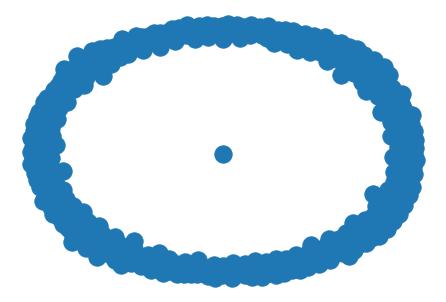

In [9]:
rides_network = nx.DiGraph()
rides_network.add_nodes_from(nodes["index"])
nx.draw(rides_network)

In [10]:
NodesPos = {}
for n in range(len(nodes)): 
    NodesPos[nodes['index'][n]] = (nodes['lon'][n], nodes['lat'][n])
        
NodesPos

{'0': (-87.62, 41.79),
 '12': (-87.74, 41.97),
 '104': (-87.75, 41.8),
 '256': (-87.7, 42.01),
 '358': (-87.61, 41.82),
 '381': (-87.68, 41.92),
 '545': (-87.66, 41.93),
 '600': (-87.63, 41.92),
 '919': (-87.78, 41.98),
 '991': (-87.7, 41.86),
 '1036': (-87.67, 41.94),
 '1073': (-87.67, 41.76),
 '1105': (-87.71, 41.78),
 '1118': (-87.66, 41.76),
 '1122': (-87.69, 42.0),
 '1158': (-87.56, 41.65),
 '1161': (-87.73, 41.95),
 '1189': (-87.7, 41.9),
 '1216': (-87.68, 41.77),
 '1220': (-87.67, 41.97),
 '1284': (-87.64, 41.8),
 '1321': (-87.7, 41.98),
 '1386': (-87.64, 41.74),
 '1507': (-87.73, 41.97),
 '1518': (-87.67, 41.71),
 '1523': (-87.68, 41.98),
 '1549': (-87.65, 41.91),
 '1585': (-87.7, 42.02),
 '1622': (-87.72, 41.85),
 '2056': (-87.7, 41.78),
 '2520': (-87.56, 41.73),
 '2795': (-87.68, 42.0),
 '3199': (-87.57, 41.75),
 '3203': (-87.71, 41.74),
 '3206': (-87.62, 41.85),
 '3209': (-87.64, 41.71),
 '3229': (-87.66, 41.73),
 '3230': (-87.61, 41.84),
 '3233': (-87.73, 41.76),
 '3237': (

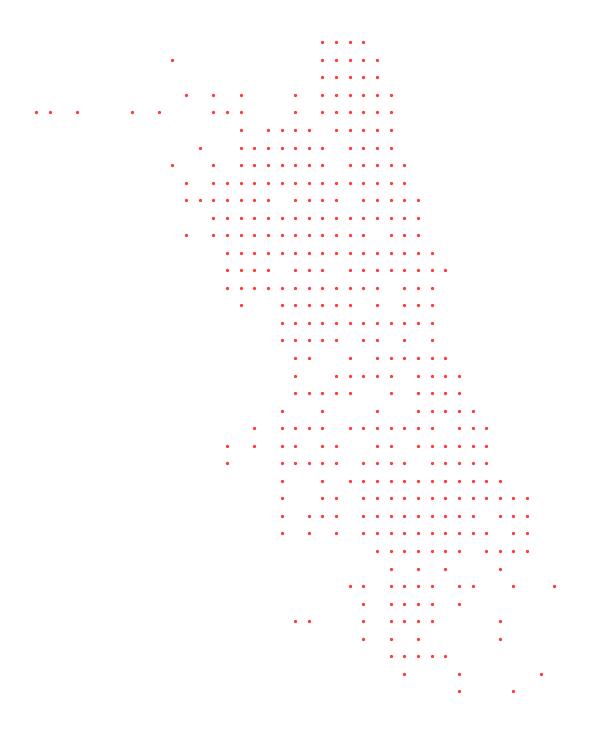

In [11]:
plt.figure(figsize=(8,10))
nx.draw(rides_network, pos=NodesPos, with_labels=False, arrows=False, node_size=5, node_color="red", alpha=0.7)


In [12]:
rides_network.add_weighted_edges_from(edgelist)

In [13]:
print(rides_network.in_degree(weight='weight')['0'])
print(rides_network.out_degree(weight='weight')['0'])

433
477


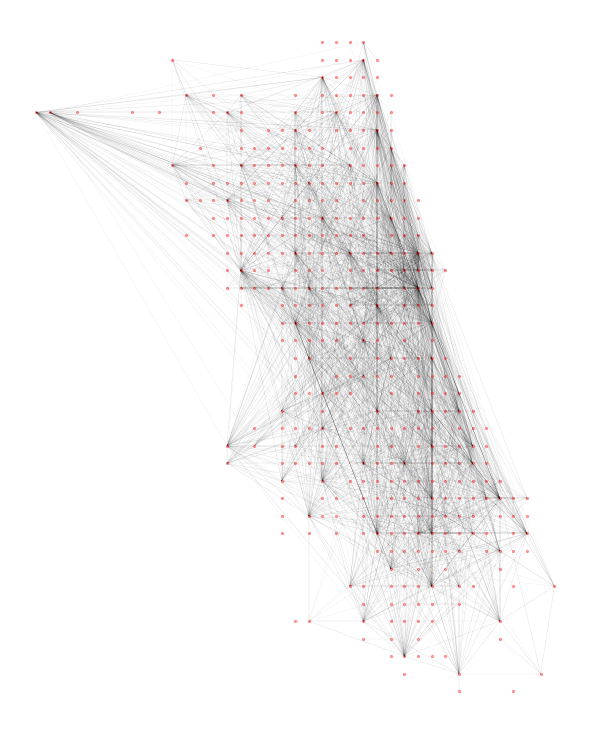

In [14]:
plt.figure(figsize=(8,10))
nx.draw(rides_network, pos=NodesPos, with_labels=False, arrows=False, node_size=5,
       node_color='red', alpha=0.35, style='dotted', edge_color='k', width=0.2)

In [15]:
in_degree = pd.DataFrame.from_dict(dict(rides_network.in_degree()), orient='index').reset_index()
in_degree.columns = ['index', 'in_degree']
out_degree = pd.DataFrame.from_dict(dict(rides_network.out_degree()), orient='index').reset_index()
out_degree.columns = ['index', 'out_degree']

in_out_degree = pd.merge(in_degree, out_degree, how='outer', on='index')

In [16]:
in_out_degree.sort_values(by='in_degree', ascending=False).head(10)

,index,in_degree,out_degree
197,4272,120,123
225,4311,91,92
256,4365,85,84
219,4305,71,66
217,4303,65,64
199,4274,64,65
210,4295,64,65
224,4310,61,58
223,4309,61,58
186,4259,59,52


In [17]:
in_out_degree.sort_values(by='out_degree', ascending=False).head(10)

,index,in_degree,out_degree
197,4272,120,123
225,4311,91,92
256,4365,85,84
219,4305,71,66
199,4274,64,65
230,4316,57,65
210,4295,64,65
217,4303,65,64
189,4262,56,64
202,4279,58,60


In [18]:
#output top ten centrality scores, given the dictionary d
def topdict(d,tn):
#     ind=sorted(d, key=dict(d).get, reverse=True)
    ind = sorted(dict(d), key=dict(d).__getitem__, reverse=True)
    for i in range(0,tn):
        print('{0}|{1}:{2}'.format(i+1,ind[i],d[ind[i]]))
        
def topkeys(d,tn): 
    ind = sorted(dict(d), key=dict(d).__getitem__, reverse=True)
    keys = []
    for i in range(0,tn): 
        keys.append(ind[i])
    return keys

In [19]:
degree_rides = nx.degree_centrality(rides_network)
topdict(degree_rides, 10)

1|4272:0.5898058252427184
2|4311:0.44417475728155337
3|4365:0.41019417475728154
4|4305:0.33252427184466016
5|4274:0.3131067961165048
6|4295:0.3131067961165048
7|4303:0.3131067961165048
8|4316:0.2961165048543689
9|4262:0.2912621359223301
10|4309:0.28883495145631066


In [20]:
# eigenvector centrality
eigen_rides = nx.eigenvector_centrality(rides_network)
topdict(eigen_rides, 10)
eigen_rides.update((x, y*250) for x, y in eigen_rides.items())

1|4272:0.19168856954531058
2|4311:0.18390014186651163
3|4305:0.17801857216132055
4|4274:0.16363935706530294
5|4310:0.15924837019733323
6|4279:0.1551436218118469
7|4303:0.15251786530053912
8|4365:0.1511244525481458
9|4293:0.15086621396510783
10|4295:0.15077775121900827


In [21]:
# closeness centrality
close_rides = nx.closeness_centrality(rides_network)
topdict(close_rides, 10)

1|4272:0.36422936893203883
2|4365:0.3318718623526549
3|4311:0.3216153368053323
4|4295:0.30415813689523075
5|4305:0.2973300970873786
6|4262:0.29552078615175564
7|4376:0.29492256593687355
8|4316:0.2943267627733647
9|4264:0.29373336204196676
10|4303:0.29373336204196676


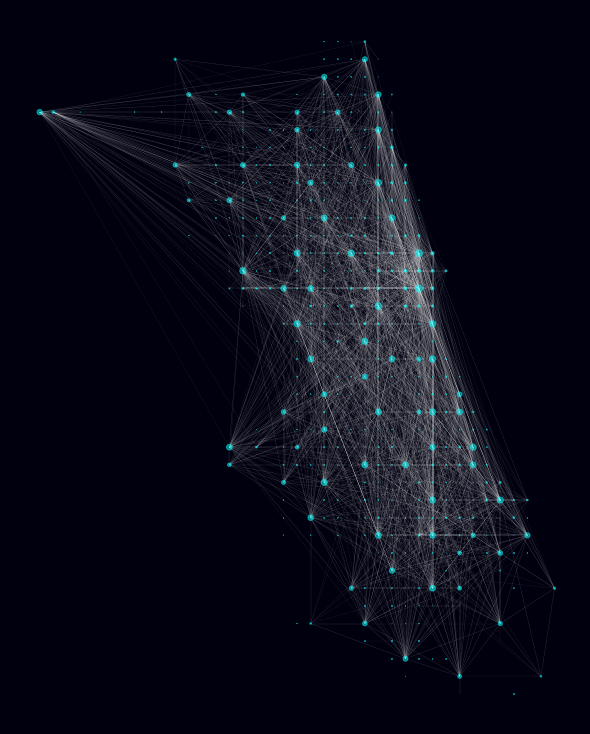

In [22]:
node_size_original = list(dict(eigen_rides).values()) # based on degree centrality

fig = plt.figure(figsize = (8,10))
nx.draw(rides_network, pos=NodesPos, with_labels=False,arrows=False, 
        node_size=node_size_original, 
       node_color='aqua', alpha=0.5, style='dotted', edge_color='white', width=0.2)
fig.set_facecolor("#00000F")

### Locate top nodes by Degree Connectivity

In [23]:
top_nodes = topkeys(degree_rides, 10)
top_nodes = nodes[nodes['index'].isin(top_nodes)]
top_nodes.head(10)

,index,latlon,lat,lon
189,4262,"(41.78, -87.64)",41.78,-87.64
197,4272,"(41.88, -87.63)",41.88,-87.63
199,4274,"(41.89, -87.76)",41.89,-87.76
210,4295,"(41.76, -87.57)",41.76,-87.57
217,4303,"(41.86, -87.72)",41.86,-87.72
219,4305,"(41.87, -87.66)",41.87,-87.66
223,4309,"(41.9, -87.72)",41.90,-87.72
225,4311,"(41.9, -87.63)",41.90,-87.63
230,4316,"(41.97, -87.66)",41.97,-87.66
256,4365,"(41.86, -87.62)",41.86,-87.62


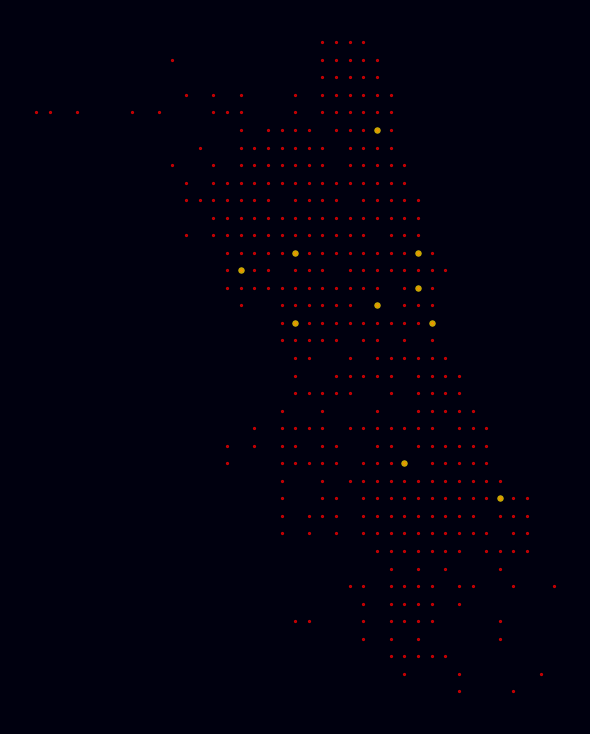

In [24]:
top_nodes_network = nx.Graph()
top_nodes_network.add_nodes_from(top_nodes["index"])

fig = plt.figure(figsize=(8,10))
nx.draw(rides_network, pos=NodesPos, with_labels=False, arrows=False, node_size=5, node_color="red", alpha=0.7, width = 0)
nx.draw(top_nodes_network, pos=NodesPos, with_labels=False, arrows=False, node_size=30, node_color="gold", alpha=0.7)
fig.set_facecolor("#00000F")